# Phase 2 Group 1 Project

## Import

In [1]:
#import appropriate libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
import statsmodels.api as sm
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
cd ..

/Users/arthur/Documents/Flatiron/phase_2/Project/dsc-phase-2-project


## Review the Data File

In [3]:
#read in the file
df = pd.read_csv('data/kc_house_data.csv')

In [4]:
#check the first 5 entries in the data
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
#check the columns and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Cleaning the Data

In [6]:
#for year renovated, convert any houses that have been renovated to '1' to indicate true
#for any nulls, assume no renovation
df['yr_renovated'].fillna(0, inplace=True)
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else x)

In [7]:
df.rename(columns={'yr_renovated': 'if_renovated'}, inplace=True)

In [8]:
#for any nulls, assume no waterfront
df['waterfront'].fillna(0, inplace=True)

In [9]:
#for any nulls, assume no one viewed the property
df['view'].fillna(0, inplace=True)

In [10]:
#clean up sqft_basement and convert to int
df['sqft_basement'] = df['sqft_basement'].replace({'?':np.nan}).astype(float)
df['sqft_basement'].fillna(df['sqft_living']-df['sqft_above'], inplace=True)

In [11]:
#retrieve the months and year
df['month_of_date'] = pd.DatetimeIndex(df['date']).month
df['year_of_date'] = pd.DatetimeIndex(df['date']).year

In [12]:
#convert yr_built to age of house by subtracting year the property was sold by the year it was built
#to create a more sensible column 
df['age_of_house'] = df['year_of_date'] - df['yr_built']

#drop year of date because years are only 2014 and 2015, and will not impact our predicative model
#drop yr_built b/c it is redundant with age_of_house
df.drop(columns=['year_of_date'], inplace=True)
df.drop(columns=['yr_built'], inplace=True)

In [13]:
#drop duplicates if any
df.drop_duplicates(inplace=True)

In [14]:
#drop id and date columns
df.drop(columns=['id'], inplace=True)
df.drop(columns=['date'], inplace=True)

In [15]:
#reset index
df.reset_index(inplace=True, drop=True)

In [16]:
#convert some of the categorical data from floats to ints
df['waterfront'] = df['waterfront'].astype(int)
df['view'] = df['view'].astype(int)
df['sqft_basement'] = df['sqft_basement'].astype(int)
df['if_renovated'] = df['if_renovated'].astype(int)

In [17]:
#check cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  int64  
 12  if_renovated   21597 non-null  int64  
 13  zipcode        21597 non-null  int64  
 14  lat            21597 non-null  float64
 15  long           21597 non-null  float64
 16  sqft_living15  21597 non-null  int64  
 17  sqft_lot15     21597 non-null  int64  
 18  month_

In [18]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,if_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_of_date,age_of_house
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,0,98178,47.5112,-122.257,1340,5650,10,59
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1,98125,47.7210,-122.319,1690,7639,12,63
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,0,98028,47.7379,-122.233,2720,8062,2,82
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,0,98136,47.5208,-122.393,1360,5000,12,49
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,0,98074,47.6168,-122.045,1800,7503,2,28


## EDA

### Target: Price

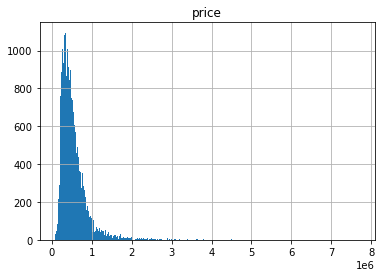

In [19]:
#Since price is our target, we will explore first
#view distribution of price using histogram
df.hist(column=['price'], bins='auto');

<AxesSubplot:>

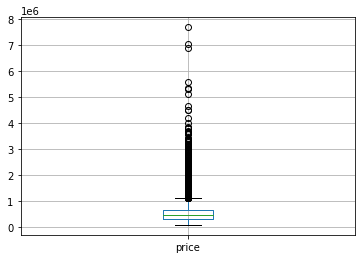

In [20]:
df.boxplot(column=['price'])

In [21]:
#Because the data is skewed to the right, transform the price data using log
df['ln_price'] = np.log(df['price'])

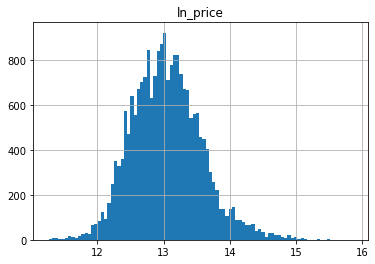

In [22]:
#view distribution of log base e for price using histogram
df.hist(column=['ln_price'], bins='auto');

<AxesSubplot:>

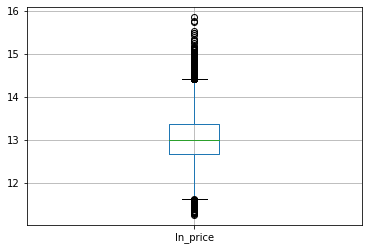

In [23]:
df.boxplot(column=['ln_price'])

### Predictors: Everything Else

In [24]:
#sns.pairplot(df)

In [25]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'if_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month_of_date', 'age_of_house',
       'ln_price'],
      dtype='object')

In [26]:
#based on the pairplot, we can see which data are categorical and which are numeric
numeric = ['bedrooms', 
           'bathrooms', 
           'sqft_living', 
           'sqft_lot', 
           'sqft_above', 
           'sqft_basement',
           'lat', 
           'long',
           'sqft_living15', 
           'sqft_lot15']

categorical = ['floors',
               'waterfront', 
               'view', 
               'condition', 
               'grade',
               'if_renovated',
               'zipcode',
               'month_of_date']

numeric_w_o_zero = ['bedrooms', 
           'bathrooms', 
           'sqft_living', 
           'sqft_lot', 
           'sqft_above', 
           'sqft_basement',
           'lat', 
           'sqft_living15', 
           'sqft_lot15']

bedrooms
0
bathrooms
0
sqft_living
0
sqft_lot
0
sqft_above
0
sqft_basement
0
lat
0
long
0
sqft_living15
0
sqft_lot15
0


In [28]:
for column in numeric_w_o_zero:
    df[column] = np.log(df[column])

/Users/arthur/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
for column in numeric:
    print(column)
    print(df[column].isnull().sum())

bedrooms
0
bathrooms
0
sqft_living
0
sqft_lot
0
sqft_above
0
sqft_basement
0
lat
0
long
0
sqft_living15
0
sqft_lot15
0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21597 non-null  float64
 12  if_renovated   21597 non-null  int64  
 13  zipcode        21597 non-null  int64  
 14  lat            21597 non-null  float64
 15  long           21597 non-null  float64
 16  sqft_living15  21597 non-null  float64
 17  sqft_lot15     21597 non-null  float64
 18  month_

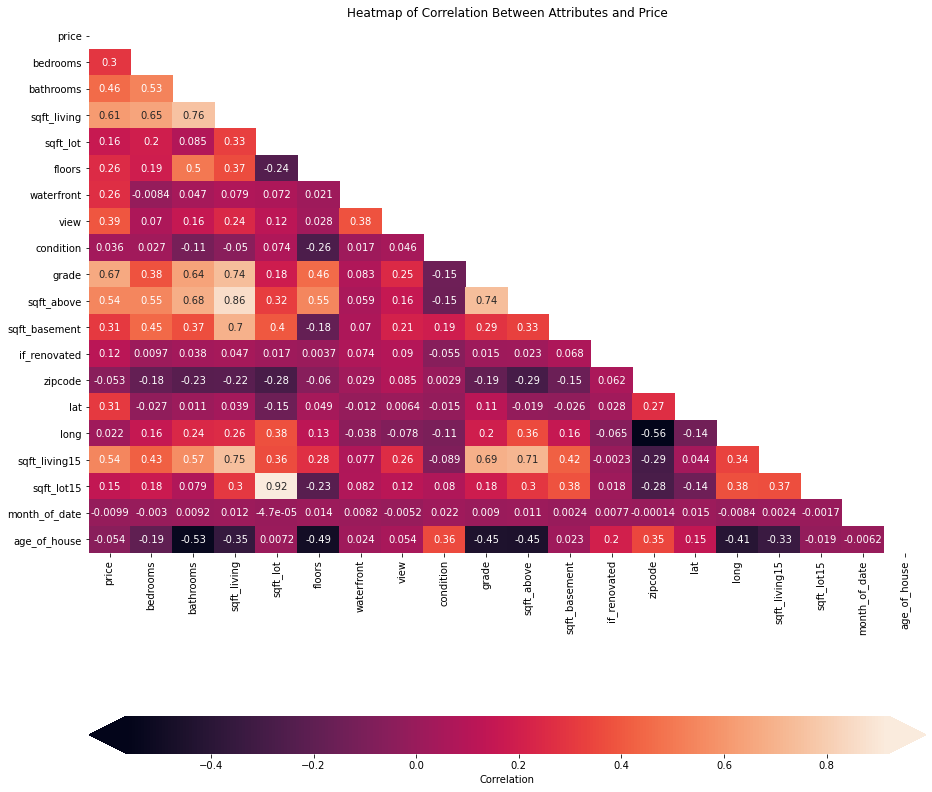

In [29]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df.drop(['price', 'ln_price'], axis = 1)
y = df['price']
ln_y = df['price']
heatmap_data = pd.concat([y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [30]:
#reporting the correlation between price (target) and predictors
df.corr()['price'].drop(['ln_price']).map(abs).sort_values(ascending=False)

price            1.000000
grade            0.667951
sqft_living      0.611839
sqft_living15    0.543829
sqft_above       0.542675
bathrooms        0.456122
view             0.393497
sqft_basement    0.307178
lat              0.306954
bedrooms         0.298844
waterfront       0.264306
floors           0.256804
sqft_lot         0.161561
sqft_lot15       0.147913
if_renovated     0.117543
age_of_house     0.053890
zipcode          0.053402
condition        0.036056
long             0.022036
month_of_date    0.009928
Name: price, dtype: float64

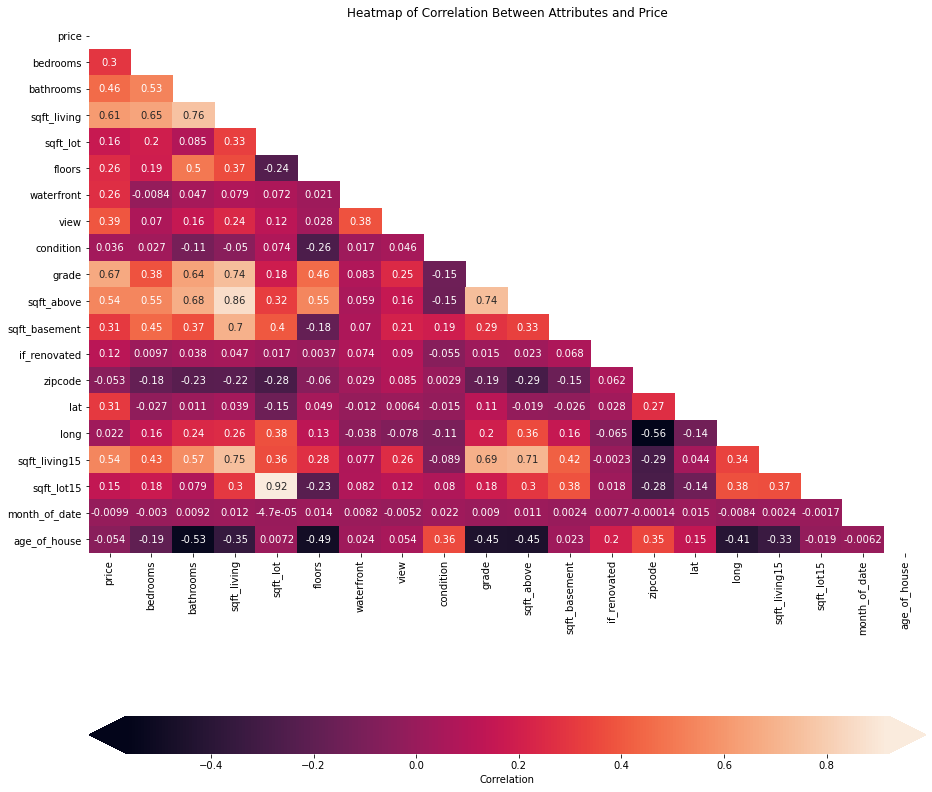

In [31]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df.drop(['price', 'ln_price'], axis = 1)
ln_y = df['price']
heatmap_data = pd.concat([ln_y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [32]:
#reporting the correlation between ln price (target) and predictors
df.corr()['ln_price'].drop(['price']).map(abs).sort_values(ascending=False)

ln_price         1.000000
grade            0.703720
sqft_living      0.674802
sqft_living15    0.607154
sqft_above       0.586013
bathrooms        0.520278
lat              0.449133
view             0.344653
bedrooms         0.342850
sqft_basement    0.328870
floors           0.310630
waterfront       0.170720
sqft_lot         0.138261
sqft_lot15       0.123710
if_renovated     0.106528
age_of_house     0.080499
long             0.050862
condition        0.038918
zipcode          0.038788
month_of_date    0.013064
Name: ln_price, dtype: float64

## Data Mainipulation

In [33]:
#creating a copy of base data
output = df

#dummying out categoricals defined in cleaning section
output = pd.get_dummies(output, prefix=categorical, prefix_sep='_', columns=categorical, drop_first=True)

#replace '.' with '_' in column names since sklearn LR has issues with '.'
output.columns = [x.replace(".","_") for x in output.columns]

#dropping targets out of predictors
X = output.drop(['price','ln_price'], axis=1)

#non-log transformed y values
y = output['price']

#log transformed y-values
ln_y = output['ln_price']

#scaling X values into z-scores
#ss = StandardScaler()
#ss.fit(X)
#X_scaled = pd.DataFrame(ss.transform(X))

#scaling process loses the column names so we're adding back
#X_scaled.columns = X.columns

#creating universal train test split for model comparison
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train2, X_test2, ln_y_train, ln_y_test = train_test_split(X, ln_y, test_size=0.20, random_state=42)

### Formulas and useful objects

In [34]:
def cross_val(estimator,X=X,y=y,n_splits=10,test_size=0.25, random_state=None):
    """
    This formula performs cross validation using shuffled splits. Output is a tuple,
    The 0th element is the median R2 score for the train sets, the 1st element
    is the median R2 score for the test sets.
    
    """
    splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    output = cross_validate(estimator, X=X, y=y, cv=splitter, return_train_score=True)
    return np.median(output['train_score']), np.median(output['test_score'])

In [35]:
def cval_summary(train,test,diff):
    return f"The median R-squared values for the train sets were {round(train,3)}, the median R-squared values for the test sets were {round(test,3)}. These values resulted in a differential of {round(diff,5)}"

In [36]:
def score_model(model,Xtrain,Xtest,ytrain,ytest):
    return model.score(Xtrain, ytrain), model.score(Xtest, ytest)

In [37]:
def model_summary(train,test,diff):
    return f"The R-squared value for the train set was {round(train,3)}, and the R-sqaured value for the test set was {round(test,3)}. These values resulted in a differential of {round(diff,5)}"

## Baseline Model

### Baseline: Target Price

In [38]:
#create a dummy regressor model based on the target as price
baseline_model = DummyRegressor(strategy='mean')
baseline_model.fit(X_train1,y_train);

In [39]:
#setting up cross validation for price in a different way (x3)
bmodel_cval = cross_val(baseline_model,
                        random_state=0)

bmodel_cval_summary = cval_summary(bmodel_cval[0],
                                   bmodel_cval[1],
                                   (abs(bmodel_cval[0]-bmodel_cval[1])))
bmodel_cval_summary

'The median R-squared values for the train sets were 0.0, the median R-squared values for the test sets were -0.0. These values resulted in a differential of 0.00017'

In [40]:
baseline_scores = score_model(baseline_model,
                              X_train1,
                              X_test1,
                              y_train,
                              y_test)

baseline_summary = model_summary(baseline_scores[0],
                                 baseline_scores[1],
                                 abs(baseline_scores[0]-baseline_scores[1]))
baseline_summary

'The R-squared value for the train set was 0.0, and the R-sqaured value for the test set was -0.0. These values resulted in a differential of 0.00029'

### Baseline: Target Log-transformed Price

In [41]:
#create `a dummy regressor model based on the target as price
baseline_ln_model = DummyRegressor(strategy='mean')
baseline_ln_model.fit(X_train2,ln_y_train);

In [42]:
bmodel_ln_cval = cross_val(baseline_ln_model,
                           y=ln_y,
                           random_state=0)

bmodel_ln_cval_summary = cval_summary(bmodel_ln_cval[0],
                                      bmodel_ln_cval[1], 
                                      abs(bmodel_ln_cval[0]-bmodel_ln_cval[1]))
bmodel_ln_cval_summary

'The median R-squared values for the train sets were 0.0, the median R-squared values for the test sets were -0.0. These values resulted in a differential of 0.00029'

In [43]:
baseline_ln_scores = score_model(baseline_ln_model,
                                 X_train2,
                                 X_test2,
                                 ln_y_train,
                                 ln_y_test)

baseline_ln_summary = model_summary(baseline_ln_scores[0],
                                    baseline_ln_scores[1],
                                    abs(baseline_ln_scores[0]-baseline_ln_scores[1]))
baseline_ln_summary

'The R-squared value for the train set was 0.0, and the R-sqaured value for the test set was -0.0. These values resulted in a differential of 0.00022'

### Summary

After running cross validation with both of our baseline models to ensure data integrity, we found from the results of our regression R-squared scores that the fit of the data we found that the cval, train and test scores were all near 0. This is to be expected of the baseline model due to it's horizontal nature. Exactly 0% of the variation in y train is predicted by a horizontal line through the mean and 100% of it is due to variance.

>The miniscule inscrease in R-squared for the test set is due to the slight change in mean from the train to test sets.

It is also worthwhile to mention that the log-transformed data performed slightly better on the test set than its non-transformed counterpart

## Model 1

Model 1 uses a multiple linear regression model of the data using all parameters, including the dummied out categorical parameters.

### Model 1: Target Price

In [44]:
#create linear regression model for price and setting up cross validation 
model1 = LinearRegression()
model1.fit(X_train1, y_train);

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#setting up cross validation for price in a different way 
model1_cval = cross_val(model1,
                           random_state=0)

model1_cval_summary = cval_summary(model1_cval[0],
                                   model1_cval[1],
                                   abs(model1_cval[0]-model1_cval[1]))
model1_cval_summary

In [ ]:
model1_scores = score_model(model1,
                            X_train1,
                            X_test1,
                            y_train,
                            y_test)

model1_summary = model_summary(model1_scores[0],
                               model1_scores[1],
                               abs(model1_scores[0]-model1_scores[1]))
model1_summary

### Model 1: Target Log-transformed Price

In [ ]:
#create linear regression model for ln price
model1_ln= LinearRegression()
model1_ln.fit(X_train2, ln_y_train);

In [ ]:
#setting up cross validation for ln price in a different way (x3)
model1_ln_cval = cross_val(model1_ln,
                           y = ln_y,
                           random_state=0)

model1_ln_cval_summary = cval_summary(model1_ln_cval[0],
                                   model1_ln_cval[1],
                                   abs(model1_ln_cval[0]-model1_ln_cval[1]))
model1_ln_cval_summary

In [ ]:
#find the test score using the linear model
model1_ln_scores = score_model(model1_ln,
                             X_train2,
                             X_test2,
                             ln_y_train,
                             ln_y_test)

model1_ln_summary = model_summary(model1_ln_scores[0],
                                  model1_ln_scores[1],
                                  abs(model1_ln_scores[0]-model1_ln_scores[1]))
model1_ln_summary

### Summary

We see that both variations of Model 1 output a higher R-squared than value than either of the Baseline models with values ranging between 0.810 and 0.880. In addition, Model 1 train and test scores varied by less than 5%. 

>The version of Model 1 that used the log-transformed price data had a .07 higher R-squared value than the untransformed price data model as well as a  .03 lower differential between train and test sets. For this reason we are going to stop using the regular price data and move forward with the transformed data.

The cross validation performed identically between these two features and did not drastically differ from our test statistics (R-squared).

In [ ]:
#Overwriting non-transformed train/test splits, to avoid confusion we will switch to simpler names
X_train = X_train2
X_test = X_test2
y_train = ln_y_train
y_test = ln_y_test

## Model 2

In Model 2 we drop features that had a relatively high p-value (alpha = 0.05) from Model 1 OLS to look for improvement in model fit.

### Filtering by p-value

In [ ]:
#set target
target = 'ln_price'

#concate the X and y of the train tests to apply the OLS to the full train data
train = pd.concat([X_train, y_train], axis=1)

#join the column names with "+"
columns= "+".join(train.drop(['ln_price'], axis=1).columns)

#set formula
formula = target + '~' +columns

#create the OLS
model1_ols = ols(formula, train).fit()

#create a dataframe for the parameters and pvalues
results = pd.DataFrame(model1_ols.pvalues)
results.reset_index(inplace=True)

#rename the columns
results.rename(columns={'index': 'parameter', 0: 'pvalue'}, inplace=True)

#create a list of parameters that have a pvalue < 0.05
parameters = list(results[results['pvalue'] < 0.05]['parameter'])

#the intercept parameter is not needed 
parameters.remove('Intercept')

In [ ]:
model1_ols.summary()

In [ ]:
import scipy.stats as stats
residuals = model1_ols.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

### Fitting the model

In [ ]:
#create linear regression model for price and setting up cross validation (x3)
model2 = LinearRegression()
model2.fit(X_train[parameters], y_train);

In [ ]:
X_train[parameters]

### Cross-Validation Step

In [ ]:
#setting up cross validation for ln price in a different way (x3)
model2_cval = cross_val(model2,
                        y=ln_y,
                        random_state=0)

model2_cval_summary = cval_summary(model2_cval[0],
                                   model2_cval[1],
                                   abs(model2_cval[0]-model2_cval[1]))
model2_cval_summary

### Model Validation

In [ ]:
#find the test score using the linear model
model2_scores = score_model(model2,
                             X_train[parameters],
                             X_test[parameters],
                             y_train,
                             y_test)

model2_summary = model_summary(model2_scores[0],
                                  model2_scores[1],
                                  abs(model2_scores[0]-model2_scores[1]))
model2_summary

### Summary

Our fit on the data has dropped drastically by removing features containing p-values greater than 0.05. In light of this signifigant decrease in accuracy we will still be relying on our "best model", which is currently model 1.

In [ ]:
#set target
target = 'ln_price'

#concate the X and y of the train tests to apply the OLS to the full train data
train = pd.concat([X_train, y_train], axis=1)

#join the column names with "+"
columns= "+".join(X_train[parameters].columns)

#set formula
formula = target + '~' +columns

#create the OLS
model2_ols = ols(formula, train).fit()

In [ ]:
residuals = model2_ols.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

## Model 3

Model 3 uses the same dataframe structure as Model 1, but introduces recursive feature elimination (REF) of varying n_parameters  to improve on the model.

### Recursive Feature Elimination (RFE)

In [ ]:
#determine how many features we have
len(X_train.columns)

In [ ]:
#determine n for REF
n = [10, 20, 50, 100]

key_cols = {}

for x in n:
    #instatiate Linear Regression
    lr_rfe = LinearRegression()
    select = RFE(lr_rfe, n_features_to_select=x)
    
    #fit model to RFE
    select.fit(X=X_train, y=y_train)
    
    #obtain the indexes where select.support_ is true
    true_indexes = [i for i, x in enumerate(select.support_) if x]
    
    #create a list of all column names matched with index and add to dictionary
    key_columns = []
    for i in true_indexes:
        key_columns.append(X_train.columns[i])
    key_cols["key_cols_{0}".format(x)] = key_columns 

In [ ]:
key_cols

In [ ]:
X_train[key_cols['key_cols_10']].shape

### Model 3: Testing 10 Features

In [ ]:
#create linear regression model for price and setting up cross validation (x3)
model3_10 = LinearRegression()
model3_10.fit(X_train[key_cols['key_cols_10']], y_train);

In [ ]:
#setting up cross validation for price in a different way (x3)
model3_10_cval = cross_val(model3,
                       X=X,
                       y=ln_y,
                       random_state=0,)

model3_10_cval_summary = cval_summary(model3_cval[0],
                                   model3_cval[1],
                                   abs(model3_cval[0]-model3_cval[1]))

model3_10_cval_summary

In [ ]:
#find the test score using the linear model
model3_10_scores = score_model(model3,
                           X_train[key_cols['key_cols_10']],
                           X_test[key_cols['key_cols_10']],
                           y_train,
                           y_test)

model3_10_summary = model_summary(model3_scores[0],
                              model3_scores[1],
                              abs(model3_scores[0]-model3_scores[1]))
model3_10_summary

### Model 3: Testing 20 Features

In [ ]:
#create linear regression model for price and setting up cross validation (x3)
model3_20 = LinearRegression()
model3_20.fit(X_train[key_cols['key_cols_20']], y_train);

In [ ]:
#setting up cross validation for price in a different way (x3)
model3_20_cval = cross_val(model3_20,
                       X=X,
                       y=ln_y,
                       random_state=0,)

model3_20_cval_summary = cval_summary(model3_20_cval[0],
                                   model3_20_cval[1],
                                   abs(model3_20_cval[0]-model3_20_cval[1]))

model3_20_cval_summary

In [ ]:
#find the test score using the linear model
model3_20_scores = score_model(model3_20,
                           X_train[key_cols['key_cols_20']],
                           X_test[key_cols['key_cols_20']],
                           y_train,
                           y_test)

model3_20_summary = model_summary(model3_20_scores[0],
                              model3_20_scores[1],
                              abs(model3_20_scores[0]-model3_scores[1]))
model3_20_summary

### Model 3: Testing 50 Features

In [ ]:
#create linear regression model for price and setting up cross validation (x3)
model3_50 = LinearRegression()
model3_50.fit(X_train[key_cols['key_cols_50']], y_train);

In [ ]:
#setting up cross validation for price in a different way (x3)
model3_50_cval = cross_val(model3_50,
                       X=X,
                       y=ln_y,
                       random_state=0,)

model3_50_cval_summary = cval_summary(model3_50_cval[0],
                                   model3_50_cval[1],
                                   abs(model3_50_cval[0]-model3_50_cval[1]))

model3_50_cval_summary

In [ ]:
#find the test score using the linear model
model3_50_scores = score_model(model3_50,
                           X_train[key_cols['key_cols_50']],
                           X_test[key_cols['key_cols_50']],
                           y_train,
                           y_test)

model3_50_summary = model_summary(model3_50_scores[0],
                              model3_50_scores[1],
                              abs(model3_50_scores[0]-model3_scores[1]))
model3_50_summary

### Model 3: Testing 100 Features

In [ ]:
#create linear regression model for price and setting up cross validation (x3)
model3_100 = LinearRegression()
model3_100.fit(X_train[key_cols['key_cols_100']], y_train);

In [ ]:
#setting up cross validation for price in a different way (x3)
model3_100_cval = cross_val(model3_100,
                       X=X,
                       y=ln_y,
                       random_state=0,)

model3_100_cval_summary = cval_summary(model3_100_cval[0],
                                   model3_100_cval[1],
                                   abs(model3_100_cval[0]-model3_100_cval[1]))

model3_100_cval_summary

In [ ]:
#find the test score using the linear model
model3_100_scores = score_model(model3_100,
                           X_train[key_cols['key_cols_100']],
                           X_test[key_cols['key_cols_100']],
                           y_train,
                           y_test)

model3_100_summary = model_summary(model3_100_scores[0],
                              model3_100_scores[1],
                              abs(model3_100_scores[0]-model3_100_scores[1]))
model3_100_summary

### Model 3: Summary

In [ ]:
print(f"10 features {model3_10_scores,(model3_10_scores[0]-model3_10_scores[1])}"),print(f"20 features {model3_20_scores,(model3_20_scores[0]-model3_20_scores[1])}"),print(f"50 features {model3_50_scores,(model3_50_scores[0]-model3_50_scores[1])}"),print(f"100 features {model3_100_scores,(model3_100_scores[0]-model3_100_scores[1])}"),print(f" Previous Best Model{model1_ln_scores,(model1_ln_scores[0]-model1_ln_scores[1])}")

Looking at the score results above it becomes apparent that the trade off for removing features from our original model is a reduced R-squared statistic. It is interesting to note however, that although the 100 feature model's r-squared statistic worsened by a minisule amount, the differental between train and test was also more narrow. This trend continues down to 50 features and then the differential begins to rise again signaling that there may be some "best" number of features for balance between r-squared and the spread between test and train.

# Model 4 Binomial Feature Engineering 

## Binomial Feature Engineering

In [ ]:
#setting up binomial features from Train/Test split that uses ln_price as a y value
pf = PolynomialFeatures(degree=2)
pf.fit(X_scaled);

In [ ]:
#Training/tranforming the data using the fit pf object. Formatting as DataFrame for ease of use
pdf_train = pd.DataFrame(pf.transform(X_train), columns = pf.get_feature_names())
pdf_test = pd.DataFrame(pf.transform(X_test), columns = pf.get_feature_names())

### Pearson Correlation Coefficient Filtering

In [ ]:
#calculating corr to the df with polynomial features to the train y values 
correlations = pdf_train.corrwith(y_train)
correlations_df = pd.DataFrame(correlations)
correlations_df.head()

In [ ]:
#NaN values represent columns containing 0 values, we wont need to consider these
correlations_df.dropna(inplace=True)

In [ ]:
#Mapping absolute value over the correlations_df to allow us to find the most impactful coefs
correlations_df[0].map(abs)
#Sorting them so that we can skim the best ones off the top
correlations_df.sort_values(by=0,ascending=False,inplace=True)

In [ ]:
#Column names of the top x number of features from our polynomial df, adding 1 to represent the intercept
features = list(correlations_df.index[:250]) + ['1']

### Recursive Feature Elimination

In [ ]:
#recrusive selector selects x numver of values from remaining features
select = RFE(lr_rfe, n_features_to_select=250)
select.fit(X = pdf_train[features], y = y_train);

In [ ]:
#compiling a list of the selected features
pdf_keepers = [x[0] for x in zip(pdf_train.columns,select.support_) 
               if x[1] == True]

### Model Validation

In [ ]:
#instantiating a linear regression object
m4df_model = LinearRegression()

In [ ]:
#fitting over traininf pdf and narrowing by selected features
m4df_model.fit(X = pdf_train[pdf_keepers], y = y_train);

In [ ]:
r2_train = m4df_model.score(pdf_train[pdf_keepers],y_train)
r2_test = m4df_model.score(pdf_test[pdf_keepers],y_test)
r2_diff = r2_train - r2_test

r2_train, r2_test, r2_diff